<a href="https://colab.research.google.com/github/dmswl0707/transfer-learning_pytorch/blob/main/transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

from __future__ import print_function, division


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
from torch.autograd import Variable 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms 
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt 

import time 
import os 
import copy


plt.ion() #interactive model


model_name="resnet"
num_classes = 2
batch_size=8
num_epochs=25
feature_extract=True


#########데이터로드##############

##데이터 불러오기-torchvision, torch.utils.data

from google.colab import drive
drive.mount('/content/drive')
data_dir='/content/drive/My Drive/Colab Notebooks/data/hymenoptera_data'

###데이터로드

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
###학습을 위한 데이터 증가(augmentation)과 일반화하기
#Data augmentation - 학습용 데이터셋의 개수가 부족할 때, 각 영상을 Rotate/Flip/Crop/Shift/Partial masking/HIS distortion 등을 적용해 데이터셋을 확장시키는 방법 
data_transform={'train': transforms.Compose([
                    transforms.RandomResizedCrop(224),#transforms.RandomResizedCrop(size) - 이미지 사이즈를 size로 변경한다
                    transforms.RandomHorizontalFlip(), #랜덤으로수평으로뒤집음
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #transforms.Normalize(mean, std, inplace=False) - 이미지를 정규화한다.
                    ]),
                'val':transforms.Compose([
                   transforms.Resize(256),
                   transforms.CenterCrop(224),
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

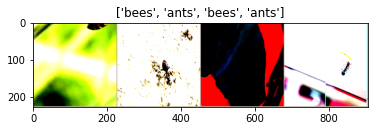

In [22]:
###이미지 예제 시각화

def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0)) #행렬 거꾸로 만들기
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std+inp+mean
    inp = np.clip(inp, 0, 1) #clip 함수 : 최소값과 최대값 조건으로 값을 기준으로 해서, 이 범위 기준을 벗어나는 값에 대해서는 일괄적으로 최소값, 최대값으로 대치
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #업데이트하기 위해 잠시 멈충

inputs, classes = next(iter(dataloaders['train']))

out=torchvision.utils.make_grid(inputs) #배치 가져오기

imshow(out,title=[class_names[x] for x in classes]) #그리드 만들기

In [32]:
####모델 학습하기

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [33]:
###모델 예측값 시각화하기 

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)
    

In [34]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5429 Acc: 0.7541
val Loss: 0.2479 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5252 Acc: 0.7623
val Loss: 0.3338 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4781 Acc: 0.7910
val Loss: 0.3089 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5068 Acc: 0.8115
val Loss: 0.4273 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5474 Acc: 0.8074
val Loss: 0.3090 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.7915 Acc: 0.7213
val Loss: 0.2920 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5528 Acc: 0.7992
val Loss: 0.4039 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4005 Acc: 0.8525
val Loss: 0.2192 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4646 Acc: 0.7992
val Loss: 0.2136 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3787 Acc: 0.8607
val Loss: 0.1945 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3009 Acc: 0.8770
val Loss: 0.1880 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2771 Acc: 0.8852
val Loss: 0.1909 Acc: 0.9412

Ep

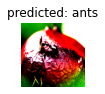

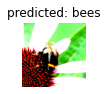

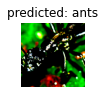

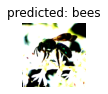

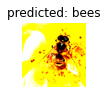

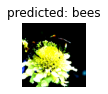

In [36]:
visualize_model(model_ft)